In [103]:
# Convolutional Neural Network (CNN) for image classification
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler

In [104]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [105]:
# Hyper-parameters 
batch_size = 100

In [106]:
# Dataset has PILImage images of range [0, 1]
# Transform the dataset to Tensors of normalized range [-1, 1]
""" 
    torchvision.transforms.Normalize(mean, std, inplace=False):
    Normalize a tensor image with mean and standard deviation.
    output[channel] = (input[channel] - mean[channel]) / std[channel]
"""
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])

# Dataset - CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # class tuple

Files already downloaded and verified
Files already downloaded and verified


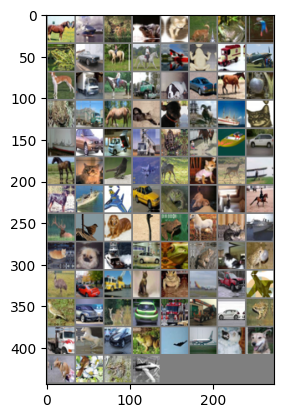

tensor([7, 8, 4, 6, 3, 5, 6, 2, 6, 1, 7, 7, 0, 6, 9, 0, 5, 9, 7, 9, 5, 1, 7, 6,
        6, 9, 7, 3, 5, 4, 8, 3, 8, 1, 9, 9, 6, 7, 8, 1, 7, 3, 2, 0, 4, 5, 4, 0,
        5, 8, 0, 1, 6, 5, 3, 7, 4, 2, 5, 2, 6, 7, 3, 8, 3, 5, 8, 1, 6, 6, 5, 6,
        2, 1, 9, 3, 6, 0, 9, 0, 2, 1, 4, 1, 9, 9, 1, 6, 9, 7, 1, 6, 0, 0, 5, 5,
        5, 2, 6, 0])


In [107]:
# Image visualization and label print
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    npimg = img.numpy() # Tensor -> numpy image
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (channels, height, weight) -> (height, weight, channels)
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# images.shape: torch.Size([4, 3, 32, 32]) -> (batch_size, channels, height, weight)

# show images
imshow(torchvision.utils.make_grid(images)) 
# torchvision.utils.make_grid(images).shape: torch.Size([3, 36, 138]) -> (channels, height, weight)

# print labels
print(labels)

In [108]:
# Convolutional Neural Network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        """ 
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
            dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        self.conv_1 = nn.Conv2d(3, 32, 3, padding='same')
        self.bn_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(32, 32, 3, padding='same')
        self.bn_2 = nn.BatchNorm2d(32)
        self.pool_1 = nn.MaxPool2d(2, 2)
        self.dropout_1 = nn.Dropout(0.3)

        self.conv_3 = nn.Conv2d(32, 64, 3, padding='same')
        self.bn_3 = nn.BatchNorm2d(64)
        self.conv_4 = nn.Conv2d(64, 64, 3, padding='same')
        self.bn_4 = nn.BatchNorm2d(64)
        self.pool_2 = nn.MaxPool2d(2, 2)
        self.dropout_2 = nn.Dropout(0.5)

        self.conv_5 = nn.Conv2d(64, 128, 3, padding='same')
        self.bn_5 = nn.BatchNorm2d(128)
        self.conv_6 = nn.Conv2d(128, 128, 3, padding='same')
        self.bn_6 = nn.BatchNorm2d(128)
        self.pool_3 = nn.MaxPool2d(2, 2)
        self.dropout_3 = nn.Dropout(0.5)

        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(128 * 4 * 4, 128)
        self.fc_2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.bn_1(F.relu(self.conv_1(x)))
        x = self.bn_2(F.relu(self.conv_2(x)))
        x = self.dropout_1(self.pool_1(x))

        x = self.bn_3(F.relu(self.conv_3(x)))
        x = self.bn_4(F.relu(self.conv_4(x)))
        x = self.dropout_2(self.pool_2(x))

        x = self.bn_5(F.relu(self.conv_5(x)))
        x = self.bn_6(F.relu(self.conv_6(x)))
        x = self.dropout_3(self.pool_3(x))
    
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [109]:
# Create the model, criterion and optimizer
num_epochs = 10
learning_rate = 0.01
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
n_total_steps = len(train_loader)

In [110]:
# Train the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin input shape: [100, 3, 32, 32] 
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [1/10], Step [100/500], Loss: 1.6876
Epoch [1/10], Step [200/500], Loss: 1.7317
Epoch [1/10], Step [300/500], Loss: 1.4464
Epoch [1/10], Step [400/500], Loss: 1.3512
Epoch [1/10], Step [500/500], Loss: 1.3141
Epoch [2/10], Step [100/500], Loss: 1.0650
Epoch [2/10], Step [200/500], Loss: 1.2048
Epoch [2/10], Step [300/500], Loss: 1.0611
Epoch [2/10], Step [400/500], Loss: 1.1159
Epoch [2/10], Step [500/500], Loss: 1.1173
Epoch [3/10], Step [100/500], Loss: 0.9914
Epoch [3/10], Step [200/500], Loss: 1.0979
Epoch [3/10], Step [300/500], Loss: 1.0954
Epoch [3/10], Step [400/500], Loss: 1.0017
Epoch [3/10], Step [500/500], Loss: 0.8427
Epoch [4/10], Step [100/500], Loss: 1.0821
Epoch [4/10], Step [200/500], Loss: 0.8946
Epoch [4/10], Step [300/500], Loss: 0.9000
Epoch [4/10], Step [400/500], Loss: 1.0470
Epoch [4/10], Step [500/500], Loss: 0.8534
Epoch [5/10], Step [100/500], Loss: 0.9694
Epoch [5/10], Step [200/500], Loss: 1.0980
Epoch [5/10], Step [300/500], Loss: 0.8086
Epoch [5/10

In [111]:
# Test the model
with torch.no_grad(): # no need to calculate gradient
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1) # max returns (value ,index)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 76.75 %
Accuracy of plane: 73.4 %
Accuracy of car: 89.1 %
Accuracy of bird: 67.6 %
Accuracy of cat: 56.9 %
Accuracy of deer: 75.4 %
Accuracy of dog: 68.6 %
Accuracy of frog: 80.2 %
Accuracy of horse: 77.3 %
Accuracy of ship: 90.8 %
Accuracy of truck: 88.2 %


In [112]:
# Save the model
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)